In [1]:
import nltk
import os, glob, math, time
import pandas as pd, numpy as np
from tqdm import tqdm
import requests
from urllib.parse import urlparse
import cv2
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
import joblib
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.utils import shuffle
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

data = 'dataset'  
os.makedirs(data, exist_ok=True)
traincsv = os.path.join(data, 'train.csv')

print("train CSV:", traincsv)

train_df = pd.read_csv(traincsv)
print(train_df.head())


train CSV: dataset\train.csv
   sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                          image_link  price  
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97  
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34  
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49  


In [2]:
df = pd.read_csv(traincsv)
print("Rows:", len(df))
print(df.columns.tolist())
display(df.head())


Rows: 75000
['sample_id', 'catalog_content', 'image_link', 'price']


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [3]:
def download_image(url, out_path, timeout=10):
    try:
        resp = requests.get(url, timeout=timeout)
        if resp.status_code == 200 and resp.content:
            with open(out_path, 'wb') as f:
                f.write(resp.content)
            return True, None
        else:
            return False, f"status_{resp.status_code}"
    except Exception as e:
        return False, str(e)


In [9]:
IMG_DIR = os.path.join(data, 'images')
os.makedirs(IMG_DIR, exist_ok=True)

MAX_DOWNLOAD = len(df) 
BATCH_DOWNLOAD = 2000 
downloaded = []
failed = []

for start in range(0, len(df), BATCH_DOWNLOAD):
    end = min(start + BATCH_DOWNLOAD, len(df))
    print(f"🔹 Download batch {start}–{end} dari {len(df)}")
    for i, row in tqdm(df.iloc[start:end].iterrows(), total=(end-start)):
        url = row.get('image_link')
        if not isinstance(url, str) or url.strip() == '':
            failed.append((i, 'no_link'))
            continue
        parsed = urlparse(url)
        ext = os.path.splitext(parsed.path)[1]
        if ext.lower() not in ['.jpg', '.jpeg', '.png', '.webp']:
            ext = '.jpg'
        outp = os.path.join(IMG_DIR, f"{i}{ext}")
        if os.path.exists(outp):
            downloaded.append((i, outp))
            continue
        ok, err = download_image(url, outp)
        if ok:
            downloaded.append((i, outp))
        else:
            failed.append((i, err))

print("Downloaded:", len(downloaded), "Failed:", len(failed))
print("Example failures:", failed[:10])


🔹 Download batch 0–2000 dari 75000


100%|██████████| 2000/2000 [00:00<00:00, 23568.93it/s]


🔹 Download batch 2000–4000 dari 75000


100%|██████████| 2000/2000 [01:53<00:00, 17.67it/s]


🔹 Download batch 4000–6000 dari 75000


100%|██████████| 2000/2000 [02:29<00:00, 13.41it/s]


🔹 Download batch 6000–8000 dari 75000


100%|██████████| 2000/2000 [02:52<00:00, 11.61it/s]


🔹 Download batch 8000–10000 dari 75000


100%|██████████| 2000/2000 [02:14<00:00, 14.91it/s]


🔹 Download batch 10000–12000 dari 75000


100%|██████████| 2000/2000 [02:33<00:00, 13.05it/s]


🔹 Download batch 12000–14000 dari 75000


100%|██████████| 2000/2000 [02:25<00:00, 13.79it/s]


🔹 Download batch 14000–16000 dari 75000


100%|██████████| 2000/2000 [02:25<00:00, 13.72it/s]


🔹 Download batch 16000–18000 dari 75000


100%|██████████| 2000/2000 [02:43<00:00, 12.27it/s]


🔹 Download batch 18000–20000 dari 75000


100%|██████████| 2000/2000 [02:48<00:00, 11.87it/s]


🔹 Download batch 20000–22000 dari 75000


100%|██████████| 2000/2000 [02:13<00:00, 15.00it/s]


🔹 Download batch 22000–24000 dari 75000


100%|██████████| 2000/2000 [02:40<00:00, 12.47it/s]


🔹 Download batch 24000–26000 dari 75000


100%|██████████| 2000/2000 [02:18<00:00, 14.41it/s]


🔹 Download batch 26000–28000 dari 75000


100%|██████████| 2000/2000 [02:14<00:00, 14.85it/s]


🔹 Download batch 28000–30000 dari 75000


100%|██████████| 2000/2000 [02:13<00:00, 14.97it/s]


🔹 Download batch 30000–32000 dari 75000


100%|██████████| 2000/2000 [02:38<00:00, 12.64it/s]


🔹 Download batch 32000–34000 dari 75000


100%|██████████| 2000/2000 [02:18<00:00, 14.48it/s]


🔹 Download batch 34000–36000 dari 75000


100%|██████████| 2000/2000 [02:37<00:00, 12.72it/s]


🔹 Download batch 36000–38000 dari 75000


100%|██████████| 2000/2000 [03:22<00:00,  9.88it/s]


🔹 Download batch 38000–40000 dari 75000


100%|██████████| 2000/2000 [03:01<00:00, 11.03it/s]


🔹 Download batch 40000–42000 dari 75000


100%|██████████| 2000/2000 [02:35<00:00, 12.85it/s]


🔹 Download batch 42000–44000 dari 75000


100%|██████████| 2000/2000 [02:52<00:00, 11.59it/s]


🔹 Download batch 44000–46000 dari 75000


100%|██████████| 2000/2000 [02:21<00:00, 14.17it/s]


🔹 Download batch 46000–48000 dari 75000


100%|██████████| 2000/2000 [03:07<00:00, 10.64it/s]


🔹 Download batch 48000–50000 dari 75000


100%|██████████| 2000/2000 [02:58<00:00, 11.20it/s]


🔹 Download batch 50000–52000 dari 75000


100%|██████████| 2000/2000 [02:37<00:00, 12.67it/s]


🔹 Download batch 52000–54000 dari 75000


100%|██████████| 2000/2000 [02:38<00:00, 12.60it/s]


🔹 Download batch 54000–56000 dari 75000


100%|██████████| 2000/2000 [02:39<00:00, 12.54it/s]


🔹 Download batch 56000–58000 dari 75000


100%|██████████| 2000/2000 [02:53<00:00, 11.56it/s]


🔹 Download batch 58000–60000 dari 75000


100%|██████████| 2000/2000 [03:03<00:00, 10.91it/s]


🔹 Download batch 60000–62000 dari 75000


100%|██████████| 2000/2000 [02:55<00:00, 11.39it/s]


🔹 Download batch 62000–64000 dari 75000


100%|██████████| 2000/2000 [03:18<00:00, 10.08it/s]


🔹 Download batch 64000–66000 dari 75000


100%|██████████| 2000/2000 [03:05<00:00, 10.77it/s]


🔹 Download batch 66000–68000 dari 75000


100%|██████████| 2000/2000 [02:58<00:00, 11.23it/s]


🔹 Download batch 68000–70000 dari 75000


100%|██████████| 2000/2000 [02:32<00:00, 13.12it/s]


🔹 Download batch 70000–72000 dari 75000


100%|██████████| 2000/2000 [02:58<00:00, 11.22it/s]


🔹 Download batch 72000–74000 dari 75000


100%|██████████| 2000/2000 [02:54<00:00, 11.43it/s]


🔹 Download batch 74000–75000 dari 75000


100%|██████████| 1000/1000 [01:15<00:00, 13.25it/s]

Downloaded: 74998 Failed: 2
Example failures: [(38945, 'status_404'), (42603, "HTTPSConnectionPool(host='m.media-amazon.com', port=443): Read timed out. (read timeout=10)")]


In [4]:
IMG_DIR = os.path.join(data, 'images')
downloaded = []

for filepath in glob.glob(os.path.join(IMG_DIR, '*')):
    filename = os.path.splitext(os.path.basename(filepath))[0]
    try:
        idx = int(filename)
    except ValueError:
        idx = filename      
    downloaded.append((idx, filepath))

print("Existing images loaded:", len(downloaded))



Existing images loaded: 76998


In [ ]:
def read_image_rgb(path, target_size=None):
    try:
        img = Image.open(path).convert('RGB')
        if target_size is not None:
            img = img.resize(target_size)
        return np.array(img)
    except:
        return None

def is_blurry(img, threshold=100):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < threshold

akaze = cv2.AKAZE_create()

def extract_akaze_descriptors_from_path(path):
    img = read_image_rgb(path)
    if img is None or is_blurry(img):
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kps, des = akaze.detectAndCompute(gray, None)
    return des



In [11]:
N = 256
BATCH_SIZE = 1500

kmeans = MiniBatchKMeans(n_clusters=N, random_state=42, batch_size=4096)
desc_buffer = []

for start in range(0, len(downloaded), BATCH_SIZE):
    batch = downloaded[start:start+BATCH_SIZE]
    sampled_descs = []
    for idx, path in batch:
        des = extract_akaze_descriptors_from_path(path)
        if des is None or len(des) == 0:
            continue
        if des.shape[0] > 64:
            perm = np.random.choice(des.shape[0], 64, replace=False)
            sampled_descs.append(des[perm])
        else:
            sampled_descs.append(des)
    if len(sampled_descs) == 0:
        continue
    all_des = np.vstack(sampled_descs)
    kmeans.partial_fit(all_des)
    print(f"Updated KMeans batch {start//BATCH_SIZE+1}")

joblib.dump(kmeans, os.path.join(data, 'models', 'kmeans_bovw.joblib'))



Updated KMeans batch 1
Updated KMeans batch 2
Updated KMeans batch 3
Updated KMeans batch 4
Updated KMeans batch 5
Updated KMeans batch 6
Updated KMeans batch 7
Updated KMeans batch 8
Updated KMeans batch 9
Updated KMeans batch 10
Updated KMeans batch 11
Updated KMeans batch 12
Updated KMeans batch 13
Updated KMeans batch 14
Updated KMeans batch 15
Updated KMeans batch 16
Updated KMeans batch 17
Updated KMeans batch 18
Updated KMeans batch 19
Updated KMeans batch 20
Updated KMeans batch 21
Updated KMeans batch 22
Updated KMeans batch 23
Updated KMeans batch 24
Updated KMeans batch 25
Updated KMeans batch 26
Updated KMeans batch 27
Updated KMeans batch 28
Updated KMeans batch 29
Updated KMeans batch 30
Updated KMeans batch 31
Updated KMeans batch 32
Updated KMeans batch 33
Updated KMeans batch 34
Updated KMeans batch 35
Updated KMeans batch 36
Updated KMeans batch 37
Updated KMeans batch 38
Updated KMeans batch 39
Updated KMeans batch 40
Updated KMeans batch 41
Updated KMeans batch 42
U

['dataset\\models\\kmeans_bovw.joblib']

In [6]:
kmeans = joblib.load(os.path.join(data, 'models', 'kmeans_bovw.joblib'))
print("KMeans loaded:", kmeans.n_clusters, "clusters")

scaler = joblib.load(os.path.join(data, 'models', 'scaler.joblib'))
reg = joblib.load(os.path.join(data, 'models', 'regressor_rf.joblib'))
print("Model & scaler loaded successfully")

features_db, ids_db = joblib.load('dataset/models/features_db.joblib')

KMeans loaded: 256 clusters
Model & scaler loaded successfully


In [7]:
def descriptors_to_bovw_hist(descriptors, kmeans):
    if descriptors is None or len(descriptors)==0:
        return np.zeros(kmeans.n_clusters, dtype=float)
    labels = kmeans.predict(descriptors)
    hist, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters+1))
    hist = hist.astype(float)
    if hist.sum()>0:
        hist = hist / hist.sum()
    return hist


In [22]:
Xs_list, ys_list = [], []

train_downloaded = [(idx, path) for idx, path in downloaded if isinstance(idx, int) and idx in df.index]
prices = np.array([df.at[idx, 'price'] for idx, _ in train_downloaded])
low, high = np.percentile(prices, [1, 99])  
valid_idx = [i for i, (idx, _) in enumerate(train_downloaded) if low <= df.at[idx, 'price'] <= high]

for i in valid_idx:
    idx, path = downloaded[i]
    des = extract_akaze_descriptors_from_path(path)
    hist = descriptors_to_bovw_hist(des, kmeans)
    if hist is None:
        continue
    Xs_list.append(hist)
    ys_list.append(df.at[idx, 'price'])

X_all = np.vstack(Xs_list)
y_all = np.array(ys_list, dtype=float)

y_all_log = np.log1p(y_all)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
reg.fit(X_scaled, y_all_log)

pred_log = reg.predict(X_scaled)
pred = np.expm1(pred_log)

print("Regression MAE:", mean_absolute_error(y_all, pred))
print("Regression R2:", r2_score(y_all_log, pred_log))

joblib.dump(reg, 'dataset/models/regressor_sgd.joblib')
joblib.dump(scaler, 'dataset/models/scaler.joblib')

Regression MAE: 6975.426555106636
Regression R2: 0.05438461031068764


['dataset/models/scaler.joblib']

In [15]:
scaler = StandardScaler()
reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)

BATCH_SIZE = 2000
Xs_list, ys_list = [], []

for start in range(0, len(downloaded), BATCH_SIZE):
    batch = downloaded[start:start+BATCH_SIZE]
    X_batch, y_batch = [], []
    for idx, path in batch:
        des = extract_akaze_descriptors_from_path(path)
        hist = descriptors_to_bovw_hist(des, kmeans)
        X_batch.append(hist)
        y_batch.append(df.at[idx, 'price'])
    X_batch, y_batch = np.vstack(X_batch), np.array(y_batch, dtype=float)
    if start == 0:
        scaler.partial_fit(X_batch)
    Xs_list.append(X_batch)
    ys_list.append(y_batch)

for Xb, yb in zip(Xs_list, ys_list):
    Xb = scaler.transform(Xb)
    reg.partial_fit(Xb, np.log1p(yb))

joblib.dump(reg, os.path.join(data, 'models', 'regressor_rf.joblib'))
joblib.dump(scaler, os.path.join(data, 'models', 'scaler.joblib'))




['dataset\\models\\scaler.joblib']

In [30]:
features_db = []
ids_db = []

for idx, path in tqdm(downloaded, desc="Extracting features for DB"):
    des = extract_akaze_descriptors_from_path(path)
    hist = descriptors_to_bovw_hist(des, kmeans)
    if hist is not None:
        features_db.append(hist)
        ids_db.append(idx)

features_db = np.vstack(features_db)
features_db = normalize(features_db, norm='l2') 

os.makedirs('dataset/models', exist_ok=True)
joblib.dump((features_db, ids_db), 'dataset/models/features_db.joblib')

Extracting features for DB: 100%|██████████| 74998/74998 [4:53:51<00:00,  4.25it/s]   


['dataset/models/features_db.joblib']

In [ ]:
def find_most_similar(query_path, features_db, ids_db, top_k=5):
    des = extract_akaze_descriptors_from_path(query_path)
    hist = descriptors_to_bovw_hist(des, kmeans)
    if hist is None:
        return []
    hist = hist.reshape(1, -1)
    hist = normalize(hist, norm='l2')
    
    sims = cosine_similarity(hist, features_db)[0]
    top_indices = sims.argsort()[::-1][:top_k]
    results = [(ids_db[i], sims[i]) for i in top_indices]
    return results

In [ ]:
checkpoint_path = 'dataset/models/eval_checkpoint.joblib'
results_path = 'dataset/models/eval_results.joblib'

top1_correct = 0
top5_correct = 0
start_idx = 0

if os.path.exists(checkpoint_path):
    print(f"[INFO] Melanjutkan dari checkpoint: {checkpoint_path}")
    checkpoint = joblib.load(checkpoint_path)
    top1_correct = checkpoint['top1_correct']
    top5_correct = checkpoint['top5_correct']
    start_idx = checkpoint['last_idx'] + 1
else:
    print("[INFO] Tidak ada checkpoint, mulai dari awal")

for i in tqdm(range(start_idx, len(downloaded)), desc="Evaluating Top-K"):
    idx, path = downloaded[i]

    if idx not in df.index:
        continue
    
    gt_product_id = df.loc[idx, 'sample_id']
    top_results = find_most_similar(path, features_db, ids_db, top_k=5)
    top_ids = [r[0] for r in top_results]
    
    if idx == top_ids[0]:
        top1_correct += 1
    if idx in top_ids:
        top5_correct += 1

    if (i + 1) % 5000 == 0 or i == len(downloaded) - 1:
        joblib.dump({
            'top1_correct': top1_correct,
            'top5_correct': top5_correct,
            'last_idx': i
        }, checkpoint_path)
        print(f"[CHECKPOINT] Disimpan di iterasi {i + 1}")

n_samples = len(downloaded)
top1_acc = top1_correct / n_samples
top5_acc = top5_correct / n_samples

joblib.dump({
    'Top-1 accuracy': top1_acc,
    'Top-5 accuracy': top5_acc
}, results_path)

print("\n=== HASIL AKHIR ===")
print("Top-1 accuracy:", top1_acc)
print("Top-5 accuracy:", top5_acc)


if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print("[INFO] Checkpoint dihapus setelah selesai.")   

[INFO] Tidak ada checkpoint, mulai dari awal


Evaluating Top-K:   6%|▋         | 5001/76998 [25:46<7:23:21,  2.71it/s] 

[CHECKPOINT] Disimpan di iterasi 5000


Evaluating Top-K:  13%|█▎        | 10000/76998 [59:37<11:36:34,  1.60it/s]

[CHECKPOINT] Disimpan di iterasi 10000


Evaluating Top-K:  19%|█▉        | 15001/76998 [1:43:12<3:59:21,  4.32it/s] 

[CHECKPOINT] Disimpan di iterasi 15000


Evaluating Top-K:  26%|██▌       | 20001/76998 [2:17:48<5:28:02,  2.90it/s] 

[CHECKPOINT] Disimpan di iterasi 20000


Evaluating Top-K:  32%|███▏      | 25000/76998 [3:00:37<6:52:58,  2.10it/s] 

[CHECKPOINT] Disimpan di iterasi 25000


Evaluating Top-K:  39%|███▉      | 30000/76998 [3:38:14<8:43:06,  1.50it/s] 

[CHECKPOINT] Disimpan di iterasi 30000


Evaluating Top-K:  45%|████▌     | 35000/76998 [4:27:58<6:55:39,  1.68it/s] 

[CHECKPOINT] Disimpan di iterasi 35000


Evaluating Top-K:  52%|█████▏    | 40001/76998 [5:17:39<2:51:20,  3.60it/s] 

[CHECKPOINT] Disimpan di iterasi 40000


Evaluating Top-K:  58%|█████▊    | 45000/76998 [5:49:27<2:55:46,  3.03it/s]

[CHECKPOINT] Disimpan di iterasi 45000


Evaluating Top-K:  65%|██████▍   | 50000/76998 [6:23:10<3:11:33,  2.35it/s]

[CHECKPOINT] Disimpan di iterasi 50000


Evaluating Top-K:  71%|███████▏  | 55000/76998 [6:58:26<2:21:46,  2.59it/s]

[CHECKPOINT] Disimpan di iterasi 55000


Evaluating Top-K:  78%|███████▊  | 60001/76998 [7:29:30<1:48:15,  2.62it/s]

[CHECKPOINT] Disimpan di iterasi 60000


Evaluating Top-K:  84%|████████▍ | 65000/76998 [8:00:12<1:53:15,  1.77it/s]

[CHECKPOINT] Disimpan di iterasi 65000


Evaluating Top-K:  91%|█████████ | 70001/76998 [8:31:27<37:50,  3.08it/s]  

[CHECKPOINT] Disimpan di iterasi 70000


Evaluating Top-K: 100%|██████████| 76998/76998 [9:03:03<00:00,  2.36it/s]  


=== HASIL AKHIR ===
Top-1 accuracy: 0.781267045897296
Top-5 accuracy: 0.8095275201953297
[INFO] Checkpoint dihapus setelah selesai.


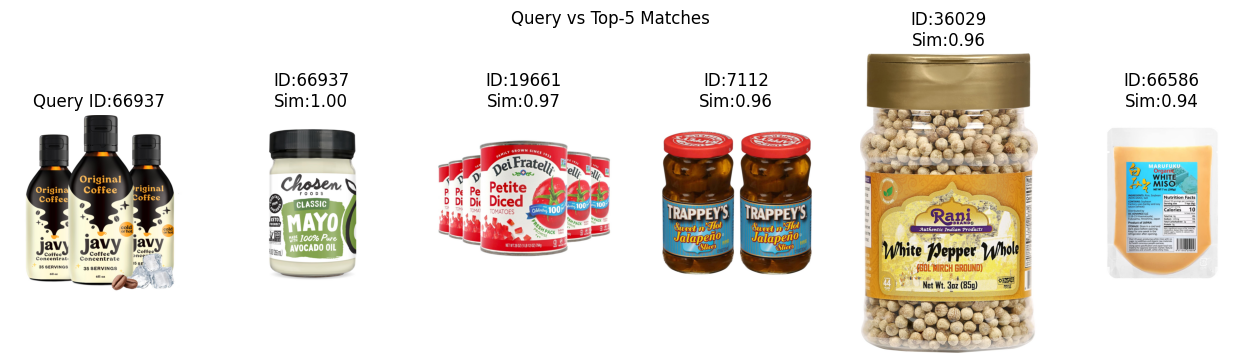

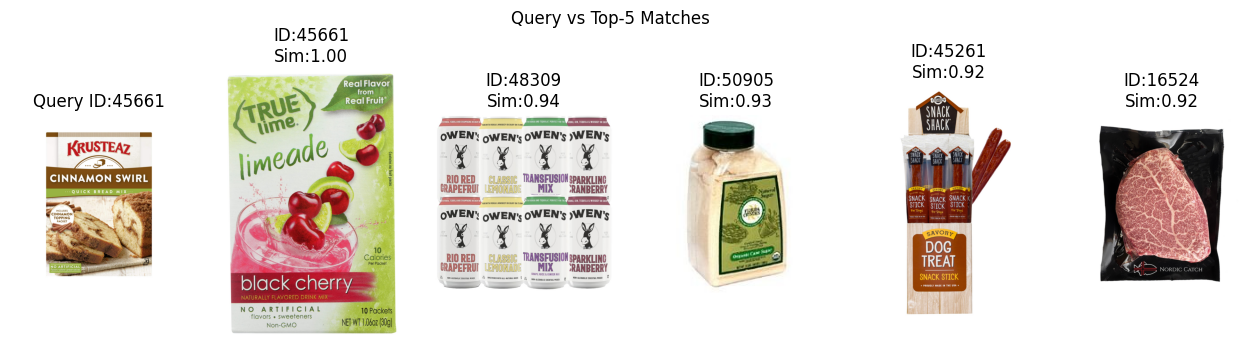

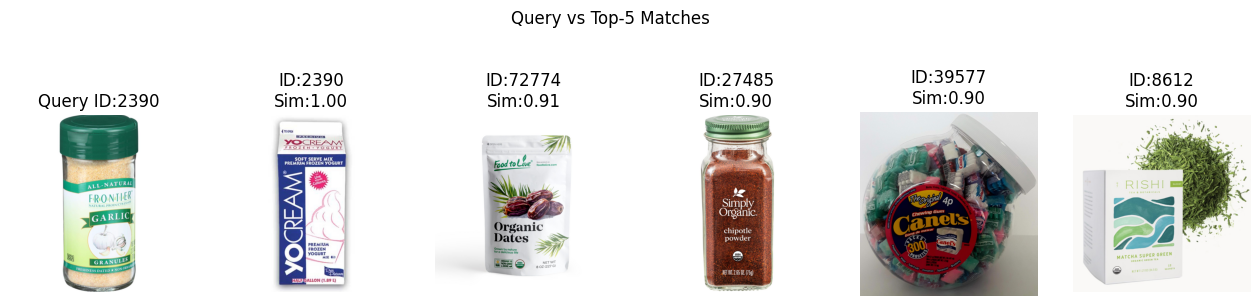

In [16]:
import random
sample_queries = random.sample(downloaded, min(3, len(downloaded)))

for query_idx, query_path in sample_queries:
    top_results = find_most_similar(query_path, features_db, ids_db, top_k=5)
    
    plt.figure(figsize=(16,4))
    query_img = Image.open(query_path).convert('RGB')
    plt.subplot(1,6,1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title(f"Query ID:{query_idx}")
    
    for i, (match_idx, sim) in enumerate(top_results):
        match_img = Image.open(downloaded[match_idx][1]).convert('RGB')
        plt.subplot(1,6,i+2)
        plt.imshow(match_img)
        plt.axis('off')
        plt.title(f"ID:{match_idx}\nSim:{sim:.2f}")
    
    plt.suptitle("Query vs Top-5 Matches")
    plt.show()